In [61]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("/Users/shreyansh/Downloads/Traffic_Incident_Calls_db.db")

df_zipcodes = pd.read_sql_query("SELECT * FROM ZipCodes", conn)
df_councildistricts = pd.read_sql_query("SELECT * FROM CouncilDistricts", conn)
df_policedistricts = pd.read_sql_query("SELECT * FROM PoliceDistricts", conn)
df_neighborhoods = pd.read_sql_query("SELECT * FROM Neighborhoods", conn)
df_locations = pd.read_sql_query("SELECT * FROM Locations", conn)
df_incidents = pd.read_sql_query("SELECT * FROM Incidents", conn)


df_locations_full = df_locations \
    .merge(df_zipcodes, on="zip_code", how="left") \
    .merge(df_councildistricts.rename(columns={"council_district_id": "council_district_id", "district_number": "council_district"}), on="council_district_id", how="left") \
    .merge(df_policedistricts.rename(columns={"police_district_id": "police_district_id", "district_name": "police_district"}), on="police_district_id", how="left") \
    .merge(df_neighborhoods.rename(columns={"neighborhood_id": "neighborhood_id", "name": "neighborhood"}), on="neighborhood_id", how="left")

df_full = df_incidents.merge(df_locations_full, on="location_id", how="left")

In [62]:
top_affected_areas = df_full.groupby(['council_district', 'police_district', 'zip_code']) \
                           .size().reset_index(name='total_incidents') \
                           .sort_values('total_incidents', ascending=False) \
                           .head(10)
print("\nMost Affected Council + Police Districts + Zip Code Areas: \n")
print(top_affected_areas.reset_index(drop=True))




Most Affected Council + Police Districts + Zip Code Areas: 

  council_district police_district zip_code  total_incidents
0       UNIVERSITY      District E    14215            17226
1            NORTH      District D    14207            14383
2         DELAWARE      District D    14216            12285
3         ELLICOTT      District B    14203             8736
4            SOUTH      District A    14220             8318
5           MASTEN      District E    14215             8304
6         FILLMORE      District C    14211             6500
7         DELAWARE      District D    14214             5790
8            NORTH      District D    14216             5691
9          LOVEJOY      District C    14211             5343


In [63]:
high_incident_addresses = (
    df_full.groupby('address')
    .size()
    .reset_index(name='incident_count')
    .query('incident_count > 500')
    .sort_values('incident_count', ascending=False)
    .head(10)
)

print(high_incident_addresses)



                                     address  incident_count
38431         SCAJAQUADA EB EX @ DELAWARE AV            1027
34687                HERTEL AV @ DELAWARE AV             854
32092                 CLINTON ST @ BAILEY AV             803
35469         KENSINGTON EB EX @E DELAVAN AV             737
38443  SCAJAQUADA EB EX @ KENSINGTON RAMP EX             667
38770                         SKYWAY INBOUND             665
38488  SCAJAQUADA WB EX @ KENSINGTON RAMP EX             654
39802                  WALDEN AV @ BAILEY AV             650
36138                  MAIN ST @ HUMBOLDT PW             648
34069                 GENESEE ST @ BAILEY AV             637


In [64]:

df_full['report_date'] = pd.to_datetime(df_full['report_date'])

incident_trends_yearly = (
    df_full.groupby(df_full['report_date'].dt.year)
    .size()
    .reset_index(name='total_incidents')
    .rename(columns={'report_date': 'year'})
    .sort_values('year')
)

print(incident_trends_yearly)




    year  total_incidents
0   2006            10506
1   2007            11825
2   2008            11875
3   2009            11330
4   2010            11504
5   2011            11197
6   2012            10153
7   2013            10838
8   2014            11346
9   2015            12382
10  2016            12367
11  2017            12379
12  2018            12462
13  2019            12414
14  2020             9697
15  2021            11052
16  2022            10548
17  2023             9867
18  2024             9952
19  2025             3614


In [65]:

df_full['report_time'] = pd.to_datetime(df_full['report_time'], errors='coerce').dt.time
df_full['report_date'] = pd.to_datetime(df_full['report_date'], errors='coerce')

df_full['hour_of_day'] = pd.to_datetime(df_full['report_time'], format='%H:%M:%S', errors='coerce').dt.hour
df_time_of_day = (
    df_full.groupby('hour_of_day')
    .size()
    .reset_index(name='incident_count')
    .sort_values('incident_count', ascending=False)
)
print(df_time_of_day)


/var/folders/jc/th9700md59x_9gd5d18c4fsw0000gn/T/ipykernel_22575/2920828149.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_full['report_time'] = pd.to_datetime(df_full['report_time'], errors='coerce').dt.time


    hour_of_day  incident_count
15           15           18689
16           16           18483
17           17           17789
14           14           15366
13           13           13548
12           12           13521
18           18           12868
11           11           11333
8             8           10779
19           19            9935
10           10            9778
9             9            9567
20           20            8099
7             7            7855
21           21            7403
22           22            6586
23           23            5437
0             0            3952
1             1            3199
6             6            3127
2             2            2873
3             3            2773
4             4            2592
5             5            1756


In [66]:
df_query_5 = (
    df_full.groupby('accident_type')
    .size()
    .reset_index(name='total_incidents')
    .sort_values('total_incidents', ascending=False)
)
print(df_query_5)



                   accident_type  total_incidents
0  ACCIDENT PROPERTY DAMAGE ONLY           161528
2                ACCIDENT/INJURY            44061
1         ACCIDENT SKYWAY/33/198            11719


In [67]:

df_full['year'] = df_full['report_date'].dt.year
df_accident_types_by_year = (
    df_full.groupby(['year', 'accident_type'])
    .size()
    .reset_index(name='total_incidents')
    .sort_values(['year', 'total_incidents'], ascending=[True, False])
)
print(df_accident_types_by_year)


    year                  accident_type  total_incidents
0   2006  ACCIDENT PROPERTY DAMAGE ONLY             8108
1   2006                ACCIDENT/INJURY             2398
2   2007  ACCIDENT PROPERTY DAMAGE ONLY             8792
4   2007                ACCIDENT/INJURY             2443
3   2007         ACCIDENT SKYWAY/33/198              590
5   2008  ACCIDENT PROPERTY DAMAGE ONLY             8699
7   2008                ACCIDENT/INJURY             2521
6   2008         ACCIDENT SKYWAY/33/198              655
8   2009  ACCIDENT PROPERTY DAMAGE ONLY             8222
10  2009                ACCIDENT/INJURY             2492
9   2009         ACCIDENT SKYWAY/33/198              616
11  2010  ACCIDENT PROPERTY DAMAGE ONLY             8311
13  2010                ACCIDENT/INJURY             2466
12  2010         ACCIDENT SKYWAY/33/198              727
14  2011  ACCIDENT PROPERTY DAMAGE ONLY             8217
16  2011                ACCIDENT/INJURY             2314
15  2011         ACCIDENT SKYWA

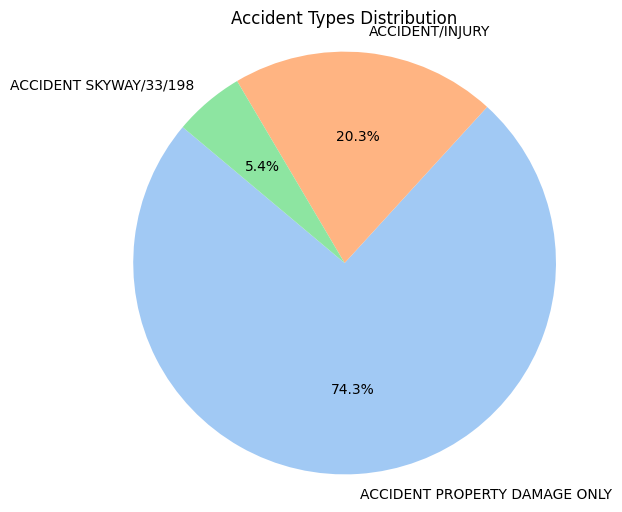

In [68]:
labels = df_query_5['accident_type']
sizes = df_query_5['total_incidents']

colors = sns.color_palette('pastel', len(labels))

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Accident Types Distribution')
plt.axis('equal')  
plt.show()


In [69]:
df_hotspots = (
    df_full.groupby(['council_district', 'police_district', 'zip_code'])
    .size()
    .reset_index(name='total_incidents')
    .sort_values('total_incidents', ascending=False)
)

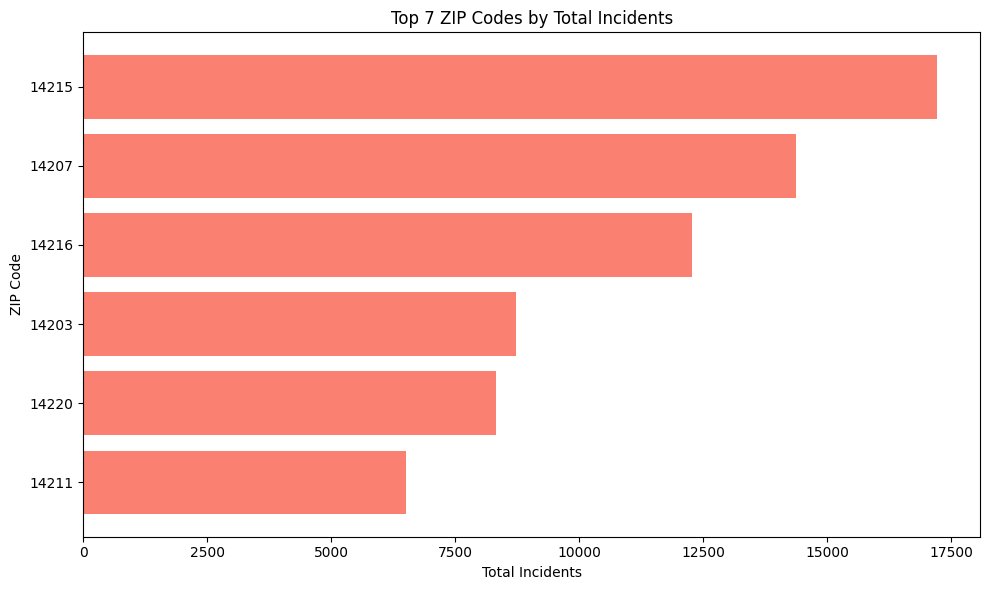

In [70]:
top_zipcodes = df_hotspots.sort_values('total_incidents', ascending=False).head(7)

plt.figure(figsize=(10, 6))
plt.barh(top_zipcodes['zip_code'].astype(str), top_zipcodes['total_incidents'], color='salmon')
plt.xlabel('Total Incidents')
plt.ylabel('ZIP Code')
plt.title('Top 7 ZIP Codes by Total Incidents')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()



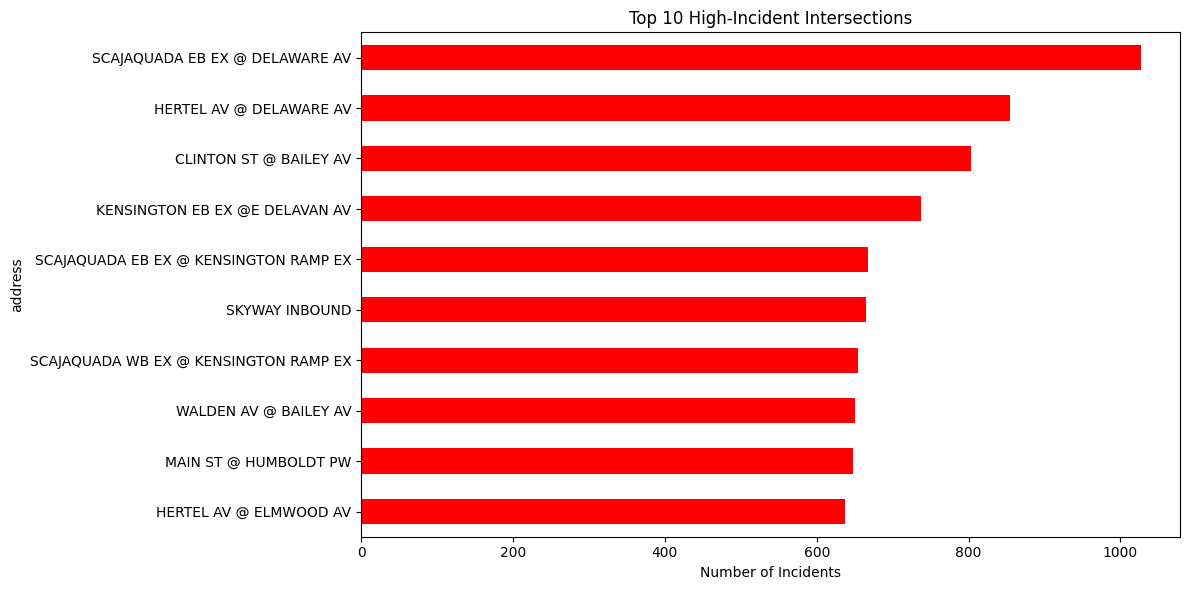

In [71]:
plt.figure(figsize=(12, 6))
top_addresses = df_full['address'].value_counts().nlargest(10)
top_addresses.plot(kind='barh', color='red')
plt.title('Top 10 High-Incident Intersections')
plt.xlabel('Number of Incidents')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


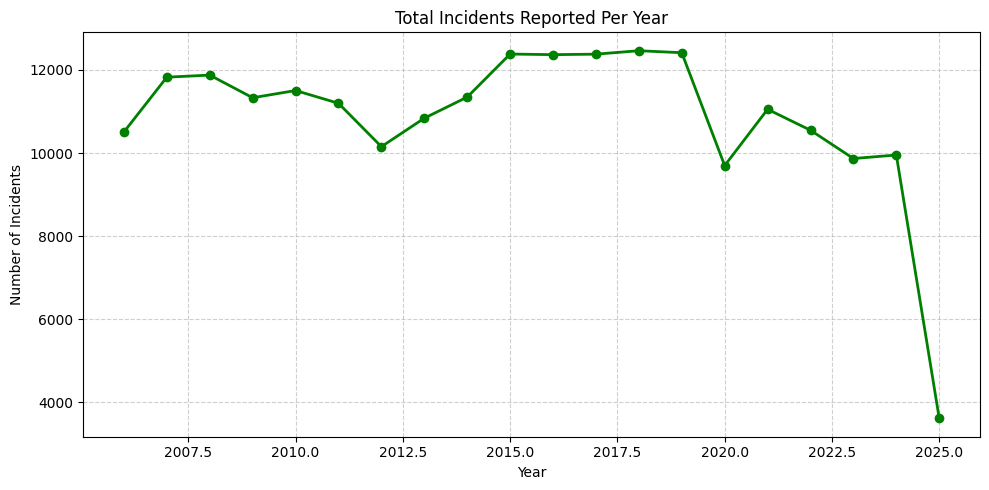

In [72]:
df_full['report_date'] = pd.to_datetime(df_full['report_date'])

df_incidents_by_year = df_full.groupby(df_full['report_date'].dt.year).size().reset_index(name='total_incidents')
df_incidents_by_year.rename(columns={'report_date': 'year'}, inplace=True)
df_incidents_by_year.columns = ['year', 'total_incidents']

plt.figure(figsize=(10, 5))
plt.plot(df_incidents_by_year['year'], df_incidents_by_year['total_incidents'], marker='o', linewidth=2, color='green')
plt.title('Total Incidents Reported Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

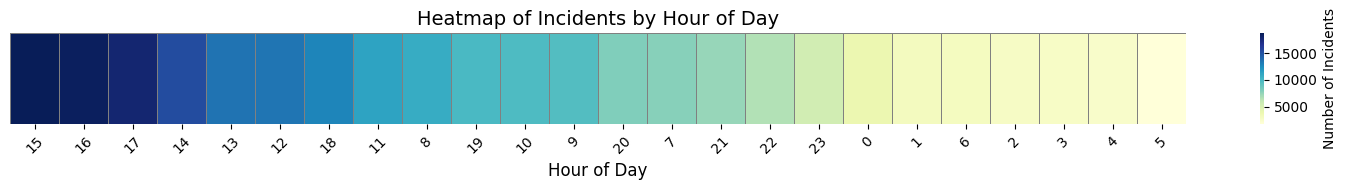

In [73]:
heatmap_data = pd.DataFrame(df_time_of_day['incident_count'].values.reshape(1, -1), 
                            columns=df_time_of_day['hour_of_day'])

plt.figure(figsize=(15, 2))

ax = sns.heatmap(
    heatmap_data, 
    cmap='YlGnBu', 
    cbar_kws={'label': 'Number of Incidents'}, 
    annot=False,          
    linewidths=0.5,       
    linecolor='gray',
    xticklabels=df_time_of_day['hour_of_day'].astype(str).tolist(), 
    yticklabels=False
)

plt.title('Heatmap of Incidents by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  
plt.tight_layout()
plt.show()